In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from typing import Optional
from torch.utils.data import DataLoader, TensorDataset

In [2]:
class SingModel(torch.nn.Module):
    def __init__(self, d:int, in_features:int, cst: float, out_features:int,w_init: Optional[Tensor] = None) -> None:
         super(SingModel, self).__init__()
         self.d = d
         if w_init is not None:
            self.weight = torch.nn.Parameter(w_init)
         else:
            self.weight = torch.nn.Parameter(torch.randn((out_features, in_features)))

    def forward(self, input:Tensor):
        # Chose cst1 and cst2 such that K(1) = 0 and K'(1) = cst
        sing = self.weight**self.d
        return input * sing 
    
# Training model

def train_model(model, data_loader, w_init: Optional[Tensor] = None, 
                linear=True, num_epochs = 1000, lr=0.01, momentum=0.9):
    trajectory = {"running loss": [], "running weight":[], "dist": []}
    # Loss and Optimizer
    loss_function = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), momentum=momentum, lr=lr)
    # Training the Model
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in data_loader:
            if linear == True:
                current_weight = model.linear.weight.item()
                trajectory["running weight"].append(current_weight)
            else:
                current_weight = model.weight.detach().clone().item()
                trajectory["running weight"].append(current_weight)
            w = current_weight
            trajectory["dist"].append(np.abs(w))
            # Forward pass
            y_pred = model(batch_x)
            loss = loss_function(y_pred, batch_y)
            # Ooptimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Tracking the cumulative loss for the current epoch
            epoch_loss += loss.item()
        # Calculate average loss for the current epoch
        avg_epoch_loss = epoch_loss / len(data_loader)
        trajectory["running loss"].append(avg_epoch_loss)
        if epoch % 10 == 0:
                        print(f'Epoch {epoch}, Loss: {loss.item()}, w: {current_weight}')
    return trajectory

# Plot loss curve

def plot_loss_curve(loss_values):
    plt.plot(loss_values)
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

# Plot loss landscape
def plot_loss_landscape(model, x_data, y_data,
                        weight_range, running_weight, linear=False):

    # Computing the loss for each weight value in the range
    loss_landscape = []
    loss_function = nn.MSELoss()

    for weight in weight_range:
        # Updating the model's weight and fixed bias
        if linear == True:
            model.linear.weight.data.fill_(weight)
        else:
            model.weight.data.fill_(weight) 
        
        # Forward pass with the updated weight
        y_pred = model(x_data)
        
        # Computing the loss
        loss = loss_function(y_pred, y_data)
        loss_landscape.append(loss.item())

    # Plotting the loss landscape
    
    plt.plot(weight_range, loss_landscape, label='Loss Landscape')

    # Plotting the trajectory of the weights during training
    plt.plot(running_weight, [loss_landscape[np.argmin(np.abs(weight_range - w))] for w in running_weight], 'o-', label='Training Path', markersize=3)
    plt.title('Weight Dynamics on Loss Landscape')
    plt.yscale("linear")
    plt.xlabel('Weight')
    plt.ylabel('Loss')
    plt.legend()


Epoch 0, Loss: 0.9866817593574524, w: -0.09997397661209106
Epoch 10, Loss: 0.9589391946792603, w: -0.09967150539159775
Epoch 20, Loss: 0.30193033814430237, w: -0.0993746891617775
Epoch 30, Loss: 0.5375885367393494, w: -0.09907976537942886
Epoch 40, Loss: 1.0770751237869263, w: -0.09879211336374283


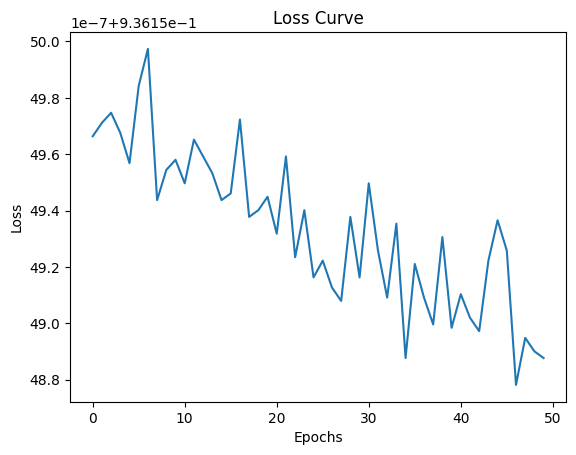

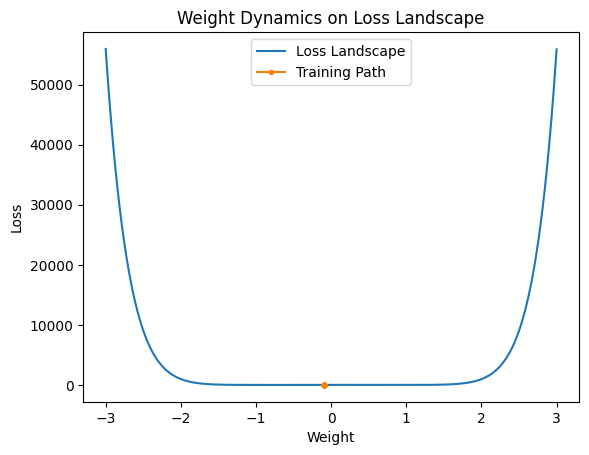

In [27]:
# Pramaters
torch.manual_seed(42) # for reproducibility
lr = 0.01
d = 5
w_init = -0.1
num_epochs = 50
num_samples = 500
batch_size = 20
cst = 0
momentum = 0.5

# Generate data
w_init = torch.Tensor([[w_init]])
torch.manual_seed(42) # for reproducibility
x_data = torch.normal(0, 1, (num_samples, 1))
y_data = torch.normal(0, 1, (num_samples, 1))
dataset = TensorDataset(x_data, y_data)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training
model = SingModel(d=d, in_features=1, out_features=1, 
                  cst=cst, w_init=w_init)
trajectory =  train_model(model, data_loader, w_init=w_init,linear=False, num_epochs = num_epochs, lr=lr, momentum=momentum)
plot_loss_curve(trajectory["running loss"])

# Plot loss landscape
weight_range = np.linspace(-3, 3, 1000)
model = SingModel(d=d, in_features=1, out_features=1, 
                  cst=cst, w_init=w_init)  # create a model instance
plt.figure()
plot_loss_landscape(model, x_data, y_data,
                        weight_range, trajectory["running weight"], linear=False)
plt.show()


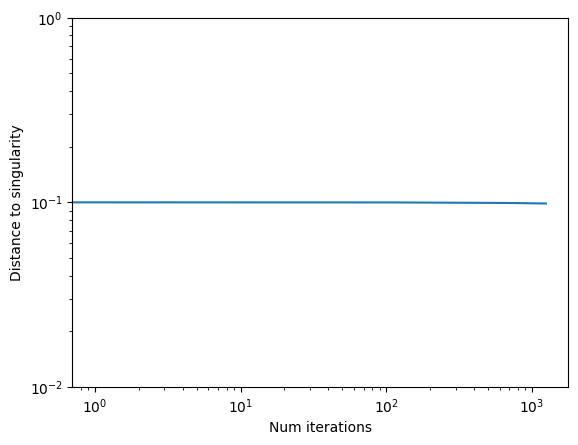

In [36]:
# Plot distance to one singularity
dist = trajectory["dist"]
plt.figure()
plt.plot(dist)
plt.ylim((0.01,1))
plt.xlabel("Num iterations")
plt.ylabel("Distance to singularity")
plt.yscale("log")
plt.xscale("log")
plt.show()

In [25]:
# Try many trajectories to see effect of degree of singularity on rate of convergence
# Pramaters
torch.manual_seed(42) # for reproducibility
trajectories = []
num_epochs = 50
num_samples = 500
cst = 0
n_traj = 4
degree = range(1,n_traj+1)

lr = 0.001
batch_size = 20
momentum = 0.5
w_init = -0.1
torch.manual_seed(42) # for reproducibility

# Training
for i in degree:
    # Generate data
    w_init = torch.Tensor([[w_init]])
    x_data = torch.normal(0, 1, (num_samples, 1))
    y_data = torch.normal(0, 1, (num_samples, 1))
    dataset = TensorDataset(x_data, y_data)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = SingModel(d=i, in_features=1, out_features=1, 
                    cst=cst, w_init=w_init)
    trajectory =  train_model(model, data_loader, w_init=w_init,linear=False, num_epochs = num_epochs, lr=lr, momentum=momentum)
    trajectories.append(trajectory)

# Pb Maybe I need to reset?

Epoch 0, Loss: 0.9962819218635559, w: -0.08647329360246658
Epoch 10, Loss: 0.9592223167419434, w: 0.005802067928016186
Epoch 20, Loss: 0.30049413442611694, w: 0.04150013625621796
Epoch 30, Loss: 0.5805271863937378, w: 0.05602782964706421
Epoch 40, Loss: 1.1164789199829102, w: 0.061457421630620956
Epoch 0, Loss: 0.934111475944519, w: 0.06186872348189354
Epoch 10, Loss: 1.147713303565979, w: 0.0563649982213974
Epoch 20, Loss: 0.9812459945678711, w: 0.05135960131883621
Epoch 30, Loss: 0.8072301149368286, w: 0.04702746868133545
Epoch 40, Loss: 1.1059455871582031, w: 0.04303455352783203
Epoch 0, Loss: 0.9761506915092468, w: 0.03963332995772362
Epoch 10, Loss: 1.0639411211013794, w: 0.04012061655521393
Epoch 20, Loss: 1.14376962184906, w: 0.040637481957674026
Epoch 30, Loss: 0.7179597616195679, w: 0.0411558635532856
Epoch 40, Loss: 0.6393303871154785, w: 0.04168813303112984
Epoch 0, Loss: 0.9272210001945496, w: 0.04217836633324623
Epoch 10, Loss: 1.0917370319366455, w: 0.04218554496765137
Ep

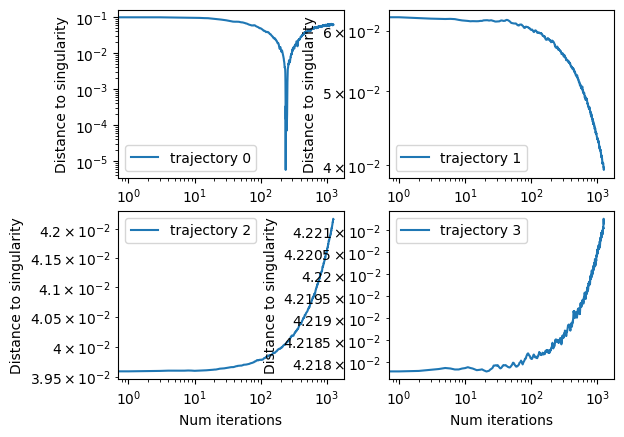

In [26]:
# Plot trajectories
for i in range(n_traj):
    trajectory = trajectories[i]
    dist = trajectory["dist"]
    plt.subplot(2,2,i+1)
    plt.plot(dist, label=f"trajectory {i}")
    plt.legend()
    plt.xlabel("Num iterations")
    plt.ylabel("Distance to singularity")
    plt.yscale("log")
    plt.xscale("log")
plt.show()

In [ ]:
# Effect of lr, batch size and momentum
# Control variables
lr = [0.01, 0.001, 0.0001]
batch_size = [5, 15, 25]
momentum = [0, 0.5, 0.9]
w_init = [-1.2]